In [117]:
import pandas as pd
from sklearn.ensemble import IsolationForest
#import shap

import os
from utils.evaluating import evaluating_change_point

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

The [SKAB](https://github.com/waico/SKAB) v0.9 corpus contains 35 individual data files in .csv format. Each file represents a single experiment and contains a single anomaly. The dataset represents a multivariate time series collected from the sensors installed on the testbed. The data folder contains datasets from the benchmark. The structure of the data folder is presented in the structure file. Columns in each data file are following:

**datetime** - Represents dates and times of the moment when the value is written to the database (YYYY-MM-DD hh:mm:ss)

**Accelerometer1RMS** - Shows a vibration acceleration (Amount of g units)

**Accelerometer2RMS** - Shows a vibration acceleration (Amount of g units)

**Current** - Shows the amperage on the electric motor (Ampere)

**Pressure** - Represents the pressure in the loop after the water pump (Bar)

**Temperature** - Shows the temperature of the engine body (The degree Celsius)

**Thermocouple** - Represents the temperature of the fluid in the circulation loop (The degree Celsius)

**Voltage** - Shows the voltage on the electric motor (Volt)

**RateRMS** - Represents the circulation flow rate of the fluid inside the loop (Liter per minute)

**anomaly** - Shows if the point is anomalous (0 or 1)

**changepoint** - Shows if the point is a changepoint for collective anomalies (0 or 1)

## Data loading

In [118]:
all_files=[]

for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [119]:
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]

anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)

In [120]:
list_of_df[0].head()

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 16:28:16,0.080968,0.132892,2.078540,0.054711,88.8333,22.0874,248.524,75.0000,0.0,0.0
2020-03-01 16:28:17,0.080721,0.137438,0.983799,0.710565,88.9111,22.0892,226.593,75.9813,0.0,0.0
2020-03-01 16:28:18,0.081400,0.128858,1.666630,0.054711,88.8676,22.0930,216.814,75.0000,0.0,0.0
2020-03-01 16:28:19,0.080755,0.135728,1.090530,0.382638,88.8907,22.0862,230.363,75.0189,0.0,0.0
2020-03-01 16:28:20,0.080394,0.132174,1.199950,0.382638,88.9437,22.0903,251.789,75.9813,0.0,0.0


In [121]:
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])

print(f'A number of changepoints in the SkAB v1.0: {n_cp}\n')
print(f'A number of outliers in the SkAB: {n_outlier}\n')

A number of changepoints in the SkAB v1.0: 130

A number of outliers in the SkAB: 13241



In [122]:
target_cols = ['anomaly', 'changepoint']
feature_cols = list_of_df[0].drop(target_cols, axis=1).columns

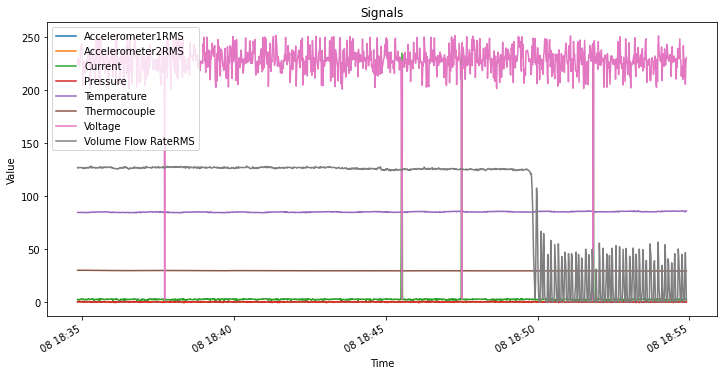

In [123]:
list_of_df[10][feature_cols].plot(figsize=(12, 6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

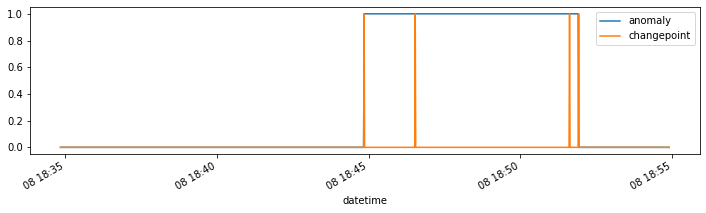

In [124]:
list_of_df[10][target_cols].plot(figsize=(12, 3))
plt.legend()
plt.show()

## Model

In [125]:
clf = IsolationForest(n_estimators=150, random_state=0, n_jobs=-1, contamination=0.02)

In [126]:
predicted_outlier, predicted_cp = [], []

for df in list_of_df:
    X_train = df[:400].drop(['anomaly', 'changepoint'], axis=1)
    clf.fit(X_train)
    prediction = pd.Series(clf.predict(df.drop(['anomaly', 'changepoint'], axis=1)) * -1, 
                                index=df.index).rolling(3).median().fillna(0).replace(-1, 0)
    
    predicted_outlier.append(prediction)
    
    prediction_cp = abs(prediction.diff())
    prediction_cp[0] = prediction[0]
    predicted_cp.append(prediction_cp)

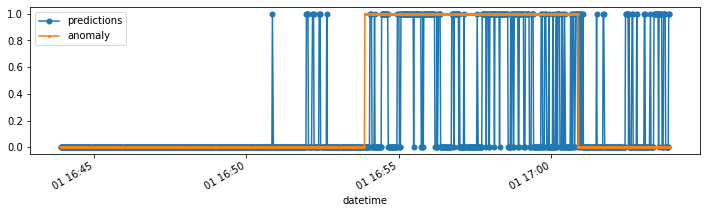

In [127]:
true_outlier = [df.anomaly for df in list_of_df]

predicted_outlier[1].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_outlier[1].plot(marker='o', markersize=2)
plt.legend()

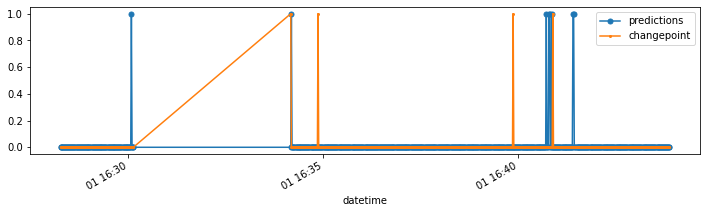

In [128]:
true_cp = [df.changepoint for df in list_of_df]

predicted_cp[0].plot(figsize=(12, 3), label='predictions', marker='o', markersize=5)
true_cp[0].plot(marker='o', markersize=2)
plt.legend()

## Evaluation

In [129]:
binary = evaluating_change_point(true_outlier, predicted_outlier, metric='binary', numenta_time='30 sec')

False Alarm Rate 10.06 %
Missing Alarm Rate 62.74 %
F1 metric 0.48


In [131]:
add = evaluating_change_point(true_cp, predicted_cp, metric='average_delay', numenta_time='30 sec')

Average delay 0 days 00:00:06.367816091
A number of missed CPs = 43
